In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Set path to your dataset folder
DATASET_PATH = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets'


Mounted at /content/drive


In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:

!pip install torchvision matplotlib scikit-learn

# Imports
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
import os
import shutil

# Source: All categories inside mvtec_anomaly_detection
mvtec_path = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_anomaly_detection'
output_path = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_binary'

# Create output folders
os.makedirs(os.path.join(output_path, 'good'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'defective'), exist_ok=True)

# Go through each category (e.g., bottle, pill)
for category in os.listdir(mvtec_path):
    category_test_path = os.path.join(mvtec_path, category, 'test')
    if not os.path.isdir(category_test_path):
        continue

    for subfolder in os.listdir(category_test_path):
        full_path = os.path.join(category_test_path, subfolder)
        if not os.path.isdir(full_path):
            continue

        for fname in os.listdir(full_path):
            src = os.path.join(full_path, fname)

            if subfolder == 'good':
                dst = os.path.join(output_path, 'good', f'{category}_{fname}')
            else:
                dst = os.path.join(output_path, 'defective', f'{category}_{subfolder}_{fname}')

            shutil.copy(src, dst)

print("✅ Dataset created at:", output_path)


✅ Dataset created at: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_binary


In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

DATASET_PATH = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_binary'

# Transform: Resize to 224x224, normalize like ResNet expects
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset
full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Split: 80% train, 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print classes
print("✅ Classes:", full_dataset.classes)
print("✅ Total Images:", len(full_dataset))
print("✅ Class indices:", full_dataset.class_to_idx)


✅ Classes: ['defective', 'good']
✅ Total Images: 1725
✅ Class indices: {'defective': 0, 'good': 1}


In [6]:
from torchvision import models
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet-50
model = models.resnet50(weights='IMAGENET1K_V1')  # New way instead of pretrained=True

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: defective, good

# Move to GPU/CPU
model = model.to(device)


Using device: cpu


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.9MB/s]


In [7]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 8  # Feel free to increase this
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/8] - Loss: 0.5759
Epoch [2/8] - Loss: 0.4975
Epoch [3/8] - Loss: 0.5371
Epoch [4/8] - Loss: 0.4880
Epoch [5/8] - Loss: 0.4507
Epoch [6/8] - Loss: 0.4381
Epoch [7/8] - Loss: 0.4307
Epoch [8/8] - Loss: 0.4235


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Print results
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

print(" Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

   defective       0.87      0.77      0.82       250
        good       0.54      0.71      0.61        95

    accuracy                           0.75       345
   macro avg       0.71      0.74      0.72       345
weighted avg       0.78      0.75      0.76       345

 Confusion Matrix:
[[193  57]
 [ 28  67]]


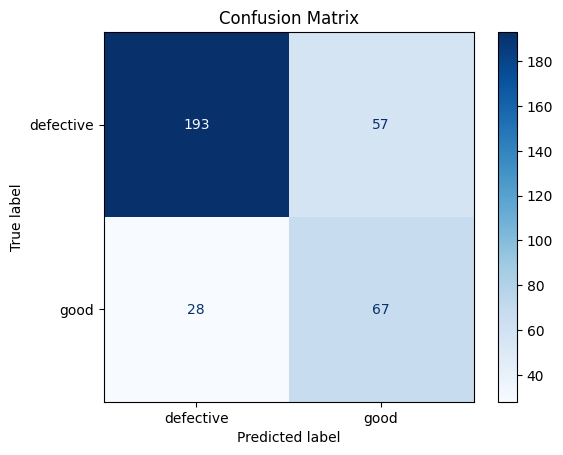

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix as image
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [13]:
import matplotlib.pyplot as plt

def show_preds(model, loader, class_names, num_images=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                image = inputs[i].cpu().permute(1, 2, 0).numpy()
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                image = np.clip(image, 0, 1)

                plt.imshow(image)
                plt.title(f"True: {class_names[labels[i]]} | Pred: {class_names[preds[i]]}")
                plt.axis('off')
                plt.show()

                shown += 1
                if shown >= num_images:
                    return


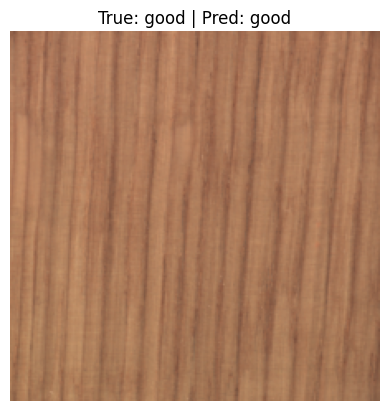

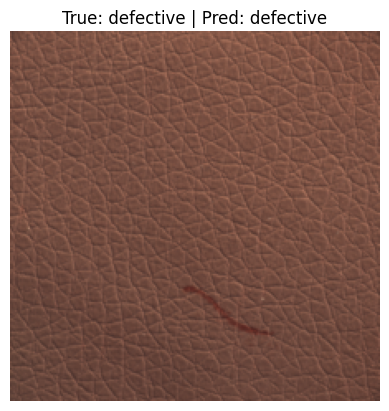

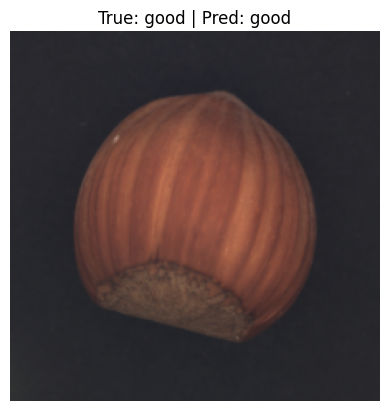

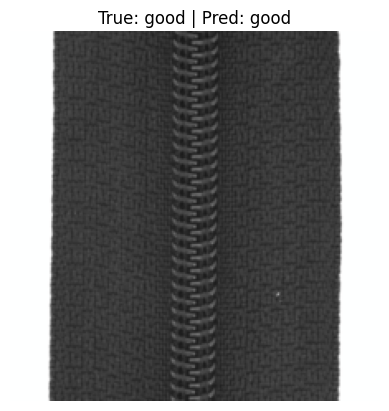

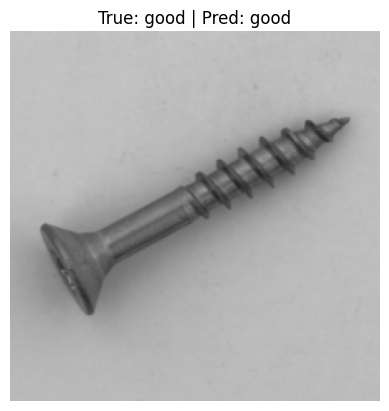

In [14]:
show_preds(model, val_loader, full_dataset.classes)


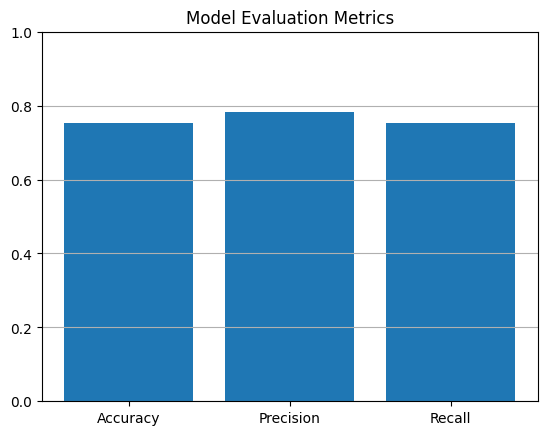

In [15]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall])
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()
